<a href="https://colab.research.google.com/github/BiancaHill/Data-Science/blob/main/BianHillUnit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how many calories you burn in a day, using time you spent exercising that day (in minutes) as a predictor.

To help you understand what you're doing with this tree, seperately create an x/y plot with time exercising as x, and calories burned as y.

If this seems to easy, then add another variable or two (type of exercise?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

A decision tree is a flow chart of possible decesions and outcomes. For example, you could make a decision tree of study time to test grade and if you studied for 1 hour you would get this grade and if you studied for more than an hour you could take the false path and get to a different study time. It works by setting criteria for each step, so the model will stop on one level if the data meets that criteria and moves to the next one if it doesn't.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The depth of a decision tree is how many layers there are or how many criteria options there are. Each node represents a new level. You're decision tree can be too deep if your model is overfitting but it can also not be deep enough if your data is much more complex than your tree.

**Task4:**

How are BART models similar and different from a decision tree?

BART models are a bunch of decision trees combines together, using randomized root nodes to let the model pick up on the different patterns expressed in each tree. This can help to prevent overfitting.

**Task5**:

Why would we use a BART model instead of a decision tree?

BART models can handle more complex relationships as they are built in sequential order by starting will all the trees and randomly alters each one based on the other trees (boosting). BART models are samples from some posterior distribution of possible random forests.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [1]:
!pip install preliz

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import preliz as pz

In [3]:
!pip install pymc-bart
import pymc_bart as pmb

In [4]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()

In [5]:
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [6]:
X = penguins[["bill_length", "flipper_length", "bill_depth"]].to_numpy()
Y = penguins["body_mass"].to_numpy()

In [7]:
with pm.Model() as model_peng:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y)
    idata_peng = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

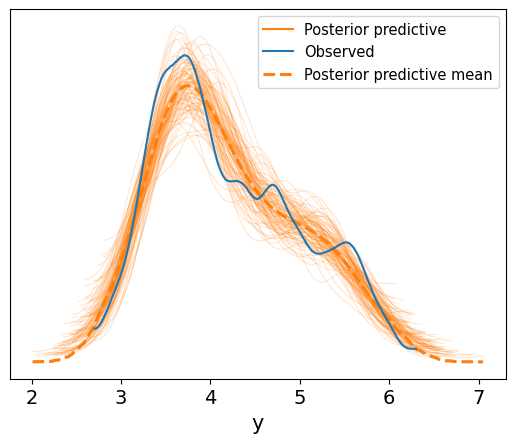

In [8]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_peng,model_peng, extend_inferencedata=True)
az.plot_ppc(idata_peng, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

<Axes: xlabel='flipper_length', ylabel='body_mass'>

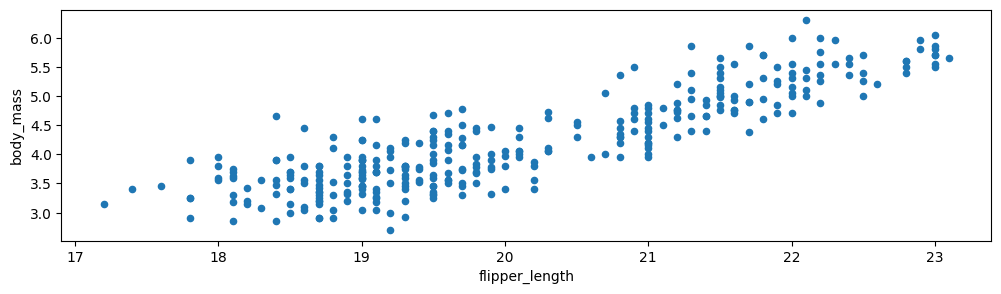

In [9]:
penguins.plot(x="flipper_length", y="body_mass", figsize=(12, 3), kind="scatter")

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


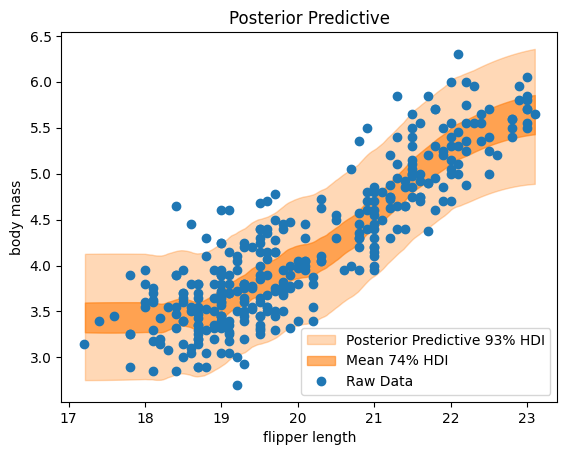

In [17]:
posterior_mean = idata_peng.posterior["μ"]

μ_hdi = az.hdi(ary=idata_peng, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_peng, group="posterior_predictive", var_names=["y"]
).T


idx = np.argsort(X[:, 1])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 1],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive 93% HDI"},
)

az.plot_hdi(
    x=X[:, 1],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean 74% HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper length",
    ylabel="body mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

Yes, it captures the association between flipper length and body mass. Flipper length should increase as body mass increases, which it does from about x=19-x=22. However, there has to be a minimum increase in body mass to see an increase in flipper length, displayed by x=17-x=19. Baby penguins have to grow (get bigger) a certain amount before you'd see an increase in flipper length. On the other end, x=22-x=23, there's a leveling off in data since it's really unusual for penguins to get past a certain body mass. While there should be a positive correlation between the two, nature requires a leveling off on both ends.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='X_0'>, <Axes: xlabel='X_1'>, <Axes: xlabel='X_2'>],
      dtype=object)

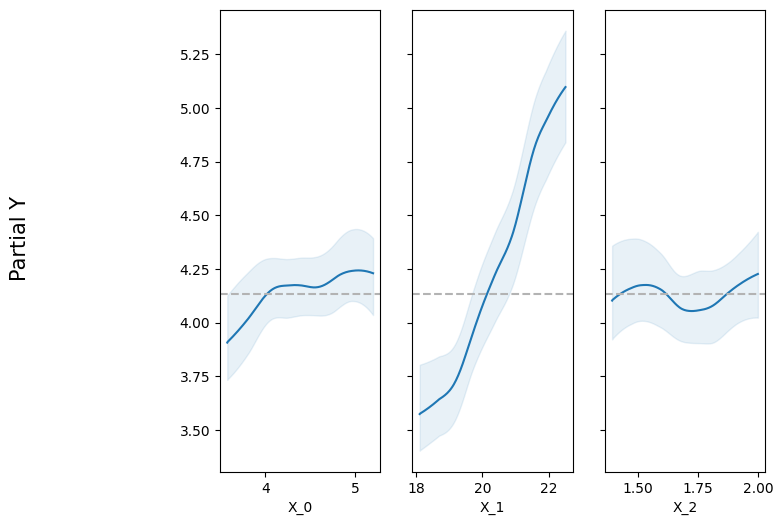

In [18]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='X_0'>, <Axes: xlabel='X_1'>, <Axes: xlabel='X_2'>],
      dtype=object)

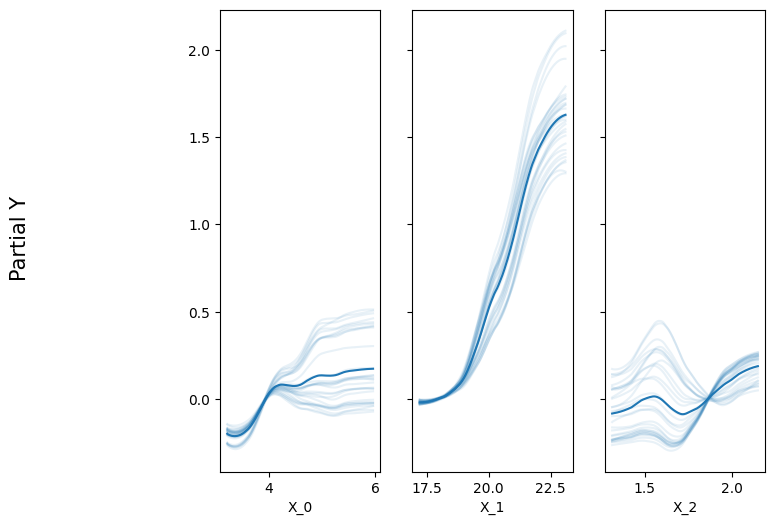

In [19]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

In [20]:
vi_peng = pmb.compute_variable_importance(idata_peng, μ_, X)

<Axes: ylabel='R²'>

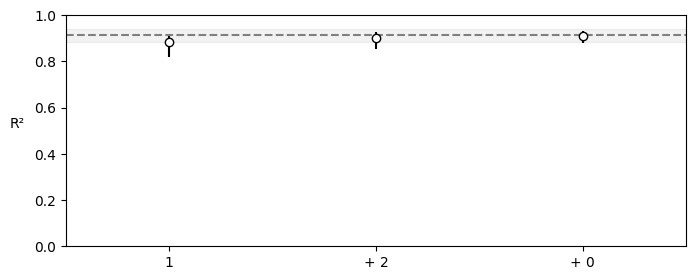

In [21]:
pmb.plot_variable_importance(vi_peng)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

- Based on the variable importance plot, flipper length is the most important variable in predicting body mass (I have flipper length second in my x variable). This is because it shows the highest jump in R^2 value. The ice plot also shows flipper length having the highest correlation of all the x values; bill length and depth have much less of a correlation.  
- Bill depth doesn't have a huge correlation but it has a small positive correlation for larger bill depths (positive from 3-4 and limited from 4-6), flipper length has a very positive correlation, and bill length has a gradual positive correlation for smaller lengths but not really correlated after that (positive for 1.75 to 2 and limited from 1.25 to 1.75).
- The relationship is complicated a bit for bill length as the difference between the pdp plot and ice plot adds a bit more curves, but the other variables are only modified at the ends. For bill length, the x=4 to x=6 area of the plot with interactions (ice plot) has have 2 peaks and 2 valleys while the the plot with no interactions (pdp plot) has only 1 of each.